# Libraries import

In [1]:
import pandas as pd
import numpy as np
import time
# Visualisation
import plotly
from bokeh.plotting import figure, output_file, show, output_notebook, ColumnDataSource
from bokeh.layouts import gridplot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Machine Learning
import h2o
from sklearn import svm, preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.datasets import make_classification
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import xgboost as xgb

# Tests Bokeh

In [65]:
def f(x):
    return x ** 2
L1 = [1, 2, 3]
L2 = [6, 10, 17]

[x + y for (x,y) in zip(L1, L2)]


[7, 12, 20]

In [38]:
# prepare some data
N = 100
x = np.linspace(0, 4*np.pi, N)
y0 = np.sin(x)
y1 = np.cos(x)
y2 = np.sin(x) + np.cos(x)

# output to static HTML file
output_file("linked_panning.html")

# create a new plot
s1 = figure(width=250, plot_height=250, title=None)
s1.circle(x, y0, size=10, color="navy", alpha=0.5)

# NEW: create a new plot and share both ranges
s2 = figure(width=250, height=250, x_range=s1.x_range, y_range=s1.y_range, title=None)
s2.triangle(x, y1, size=10, color="firebrick", alpha=0.5)

# NEW: create a new plot and share only one range
s3 = figure(width=250, height=250, x_range=s1.x_range, title=None)
s3.square(x, y2, size=10, color="olive", alpha=0.5)

# NEW: put the subplots in a gridplot
p = gridplot([[s1, s2, s3]], toolbar_location=None)

# show the results
show(p)

# Data Processing

In [12]:
df = pd.read_csv('data/train.csv')

In [13]:
Y = np.array(df['SalePrice'])
df.drop(['SalePrice', 'Id'], axis=1, inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 79 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

In [15]:
# fillna
dico_fill_na = {}
col_drop = ['Id']
for col in df.columns:
    if df[col].isnull().sum() > 8 * len(df) / 10:
        col_drop.append(col)
        df.drop(col, axis=1, inplace=True)
    elif str(df[col].dtype).endswith('64'):
        dico_fill_na[col] = df[col].mean()
        df[col].fillna(dico_fill_na[col], inplace=True)
    else:
        dico_fill_na[col] = df[col].mode()[0]
        df[col].fillna(dico_fill_na[col], inplace=True)
        df[col] = df[col].astype('category').cat.codes

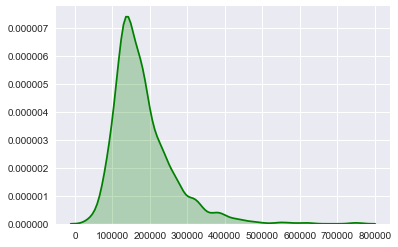

In [16]:
sns.kdeplot(Y, shade="True", color="green")

# Modelisation Part

In [17]:
def error_function(y_pred, y_true):
    return np.sqrt(np.mean((np.log(y_pred) - np.log(y_true)) ** 2))

In [18]:
# train_test_split
X = np.array(df)
X_train, X_test, y_train, y_test = train_test_split(
    X, np.array(Y), test_size=0.2)

### RF

In [19]:
clf = RandomForestRegressor(n_estimators=100)
try:
    cross_val_score(clf, X, Y, cv=5, scoring=error_function)
except TypeError:
    print("TypeError")
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# error_function(y_pred, y_test)

TypeError


### Extra_Trees

In [20]:
clf = ExtraTreesRegressor(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
error_function(y_pred, y_test)

0.15522587056207332

### Linear Regression

In [460]:
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
error_function(y_pred, y_test)

0.16755064605088626

### Kernel Ridge

In [441]:
clf = KernelRidge(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
error_function(y_pred, y_test)

0.16754574470067204

### Ridge

In [454]:
clf = Ridge(alpha=200)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
error_function(y_pred, y_test)

0.16527451742535135

### Lasso

In [459]:
clf = Lasso(alpha=500)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
error_function(y_pred, y_test)

0.16574578578014884

### ElasticNet

In [439]:
clf = ElasticNet()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
error_function(y_pred, y_test)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.16714250803062183

### XGBoost

In [489]:
for i in range(1, 10):
    clf = xgb.XGBRegressor(learning_rate=0.1 * i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(error_function(y_pred, y_test))

0.14713814515266607
0.14457595064328657
0.14723523152677598
0.15914105028571895
0.1594101332592231
0.16643633000798125
0.18394795570704806
0.1711196311910514
0.19091802880338898


### on garde seulement les features importantes

In [22]:
clf_bis = RandomForestRegressor(n_estimators=100)
clf_bis.fit(X_train, y_train)
y_pred = clf_bis.predict(X_test)

In [355]:
np.where(clf.feature_importances_ > 0.1)

(array([15, 44]),)

In [23]:
error_function(y_pred=y_pred, y_true=y_test)

0.16184842144479433

In [30]:
#output_notebook()
p = figure(y_range=[100, 10 ** 6], title="log axis example",
   x_axis_label='sections', y_axis_label='particles'
)
p.circle(y_test, y_pred)
show(p)

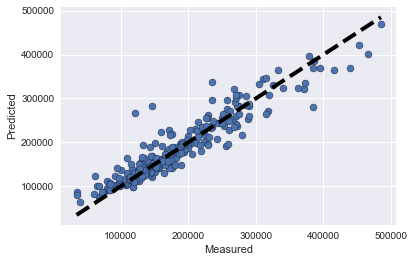

In [24]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [263]:
plt.plot(y)

array([154500, 325000, 115000, 159000, 315500,  75500, 311500, 146000,
        84500, 135500, 145000, 130000,  81000, 214000, 181000, 134500,
       183500, 135000, 118400, 226000, 155000, 210000, 173500, 129000,
       192000, 153900, 181134, 141000, 181000, 208900, 127000, 284000,
       200500, 135750, 255000, 140000, 138000, 219500, 310000,  97000,
       114500, 205000, 119500, 253293, 128500, 117500, 115000, 127000,
       451950, 144000, 119000, 196000, 115000, 287000, 144500, 260000,
       213000, 175000, 107000, 107500,  68500, 154000, 317000, 264132,
       283463, 243000, 109000, 305000,  93500, 176000, 118858, 134000,
       109008,  93500, 611657, 173000, 348000, 341000, 141000, 124900,
       118000,  67000, 113000,  91300, 149500, 133000, 266000, 190000,
       155900, 155835, 153500, 152000, 124500, 301000, 136500, 169990,
       205000, 183900, 204900, 260000, 163500, 224900, 244000, 132000,
       194000, 156500, 156000, 275000, 145000, 135000,  60000, 124000,
      

# Submission Part

In [476]:
df_test = pd.read_csv('data/test.csv')

In [477]:
df_test.drop(col_drop, axis=1, inplace=True)
df_test.fillna(dico_fill_na, inplace=True)
print()

In [478]:
for col in df_test.select_dtypes(include=['object']).columns:
    df_test[col] = df_test[col].astype('category').cat.codes

In [479]:
clf = xgb.XGBRegressor(learning_rate=0.2)
clf.fit(X, Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [480]:
y_pred = clf.predict(np.array(df_test))

In [481]:
Id = np.arange(1461, 2920)
dico = {'Id' : Id, 'SalePrice': y_pred}
solution = pd.DataFrame(data=dico)

In [482]:
solution.to_csv(index=False, path_or_buf='./data/sample_submission.csv')

In [298]:
pd.read_csv("./data/sample_submission.csv")

,Id,SalePrice
0,1461,124961.00
1,1462,154349.32
2,1463,186424.80
3,1464,182782.50
4,1465,201129.96
5,1466,182666.20
6,1467,164317.44
7,1468,176991.57
8,1469,177224.84
9,1470,119375.68
